In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from matplotlib.pyplot import imshow
from sklearn.metrics import f1_score

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(device)

cuda


In [19]:
transform = transforms.Compose([ 
    transforms.Resize(size=(180, 180)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dir= "./data/train" # path to the train folder
validation_dir= "./data/validation" # path to the validation folder
test_dir = "./data/test" # path to test folder

train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=transform) 

validation_data = datasets.ImageFolder(root=validation_dir, 
                                 transform=transform)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=transform)


print(f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}\n\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 3689
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 495
    Root location: ./data/validation
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 494
    Root location: ./data/test
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.

In [20]:
batch_size = 4
num_workers = 2

train_set = DataLoader(dataset=train_data, 
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=num_workers, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

validation_set = DataLoader(dataset=validation_data, 
                             batch_size=batch_size, 
                             num_workers=num_workers, 
                             shuffle=True) # dont usually need to shuffle validation data

test_set = DataLoader(dataset=test_data, 
                             batch_size=batch_size, 
                             num_workers=num_workers, 
                             shuffle=True) # dont usually need to shuffle testing data

train_set,validation_set,test_set

(<torch.utils.data.dataloader.DataLoader at 0x25e6e926c20>,
 <torch.utils.data.dataloader.DataLoader at 0x25e6e925780>)

In [ ]:
# I create train_data above , and I will use it here 
label_dict = {y: x for x, y in train_data.class_to_idx.items()}

# Define a function to display images
def show_images(images, labels):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        image = to_pil_image(images[i])  # Convert tensor to PIL Image
        plt.imshow(image)
        plt.title(label_dict[labels[i].item()])  # Convert numerical label to string label
        plt.axis('off')
    plt.show()

# Get the first batch
for batch_idx, (images, labels) in enumerate(train_set):
    if batch_idx == 0:  # Only process the first batch
        show_images(images, labels)
        break

In [22]:
from models.model1 import SimpleCNN1
from models.modelv2 import SimpleCNN2
from models.modelv3 import SimpleCNN3
from models.modelv4 import SimpleCNN4
from models.modelv5 import SimpleCNN5

model1 = SimpleCNN1()
model2 = SimpleCNN2()
model3 = SimpleCNN3()
model4 = SimpleCNN4()


model1 = model1.to(device)
model2 = model2.to(device)
model3 = model3.to(device)
model4 = model4.to(device)

In [23]:
# I am going to add accuracies to these lists and I will use them outside of this function 
train_accuracies=[]
validation_accuracies=[]

# Function for training
def train(dataloader, model, loss_fn, optimizer, epoch):
    
    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches
    
    model.train()

    train_loss, correct = 0, 0
    

    for batch, (X, y) in enumerate(dataloader):
        # move X and y to GPU for faster training
        X, y = X.to(device), y.to(device) 

        # make prediction 
        pred = model(X)
        # calculate loss 
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward() # compute parameters gradients
        optimizer.step() # update parameters
        optimizer.zero_grad() #  reset the gradients of all parameters

        # Update training loss
        train_loss += loss.item() # item() method extracts the loss’s value as a Python float

        # Calculate training accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            print(f'batch {batch} completed, train_loss={train_loss}')
    
    # loss and accuracy
    train_loss = train_loss / num_batches
    accuracy = 100 * correct / size
    
    # use this accuracy list for plotting accuracy with matplotlib
    train_accuracies.append(accuracy)

    # Print training accuracy and loss at the end of epoch
    print(f" Training Accuracy: {accuracy:.2f}%, Training Loss: {train_loss:.4f}")

def validation(dataloader, model, loss_fn, t):
    
    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches
    
    validation_loss, correct = 0, 0
    
    # sets the PyTorch model to evaluation mode, it will disable dropout layer
    model.eval()
    
    with torch.no_grad(): #  disable gradient calculation
        for X, y in dataloader:
            
            # move X and y to GPU for faster training
            X, y = X.to(device), y.to(device)
            pred = model(X) # make prediction
            validation_loss += loss_fn(pred, y).item() 
            
            # if prediction is correct add 1 to correct variable.
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size

    validation_accuracies.append(accuracy)

    # Print test accuracy and loss at the end of epoch
    print(f" Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}")

In [24]:
# Loss funciton, optimizer and epochs
loss_fn = nn.CrossEntropyLoss()
optimizers = [
    torch.optim.SGD(model.parameters(), lr=1e-3)
    for model in [model1, model2, model3, model4]
]
epochs = 20

In [ ]:
# extra loggin while training
models = [model1, model2, model3, model4]

# loop for training model
for i, (model, optimizer) in enumerate(zip(models, optimizers)):
    print(f"\n=== Training Model {i+1} ===")

    for t in range(epochs):
        print(f"Epoch {t+1} for Model {i+1}")

        train(train_set, model, loss_fn, optimizer, t)

        validation(validation_set, model, loss_fn, t)
        print("----------------------------")

print("Done!")

In [28]:
BASE_PATH = './nets/'

models = [model1, model2, model3, model4]
model_names = ["skynet1.pth", "skynet2.pth", "skynet3.pth", "skynet4.pth"]

for model, name in zip(models, model_names):
    path = BASE_PATH + name
    torch.save(model.state_dict(), path)

In [25]:
BASE_PATH = './nets/'

models = [
    SimpleCNN1().to(device),
    SimpleCNN2().to(device),
    SimpleCNN3().to(device),
    SimpleCNN4().to(device),
    SimpleCNN5().to(device),
]
model_names = [
    "skynet1.pth",
    "skynet2.pth",
    "skynet3.pth",
    "skynet4.pth",
    "skynet5.pth",
]

for model, name in zip(models, model_names):
    path = BASE_PATH + name
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Model weights loaded from: {path}")

E:\AppData\Local\Temp\ipykernel_16700\2932371705.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Model weights loaded from: ./nets/skynet1.pth
Model weights loaded from: ./nets/skynet2.pth
Model weights loaded from: ./nets/skynet3.pth
Model weights loaded from: ./nets/skynet4.pth
Model weights loaded from: ./nets/skynet5.pth


## MODEL ANALYSIS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  refuse accept refuse refuse


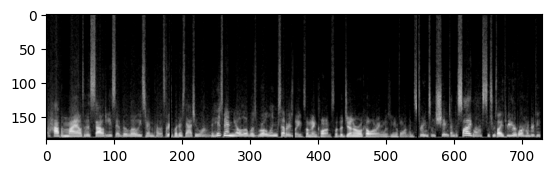

In [26]:
classes = [ 'accept', 'refuse' ]

dataiter = iter(validation_set)
images, labels = next(dataiter)

# print images
img_grid = torchvision.utils.make_grid(images).permute(1, 2, 0)

imshow(img_grid)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### CNN layers visualization

In [38]:
def plot_layers(model, images):
    # Defined only for model with 4 layers
    if not hasattr(model, 'conv4'):
        return
    # Assume we already have the SimpleCNN network defined
    # imported or defined in a separate file:
    
    # Dictionary to store the outputs from the layers
    activations = {}
    
    # Hook function: name plus the input and output from the layer
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
    
        return hook
    
    # Register hooks for selected layers. For example: conv1, conv2, conv3, conv4
    model.conv1.register_forward_hook(get_activation("conv1"))
    model.conv2.register_forward_hook(get_activation("conv2"))
    model.conv3.register_forward_hook(get_activation("conv3"))
    model.conv4.register_forward_hook(get_activation("conv4"))
    
    # Pass the images through the network (forward)
    _ = model(images)
    
    # Let's show several of the first feature maps (e.g. 6)
    for l in range(4):
        fig, axs = plt.subplots(4, 8, figsize=(20, 10))
        axs = axs.flatten()
        conv = f"conv{l + 1}"
        act = activations[conv][0]  # Now shape: (C, H, W)
        print(f"{conv} shape ([C, H, W]):", list(act.shape))
        for i in range(min(act.size()[0], 32)):
            channel_map = act[i].numpy()
            axs[i].imshow(channel_map, cmap="gray")
            axs[i].axis("off")
            axs[i].set_title(f"Channel {i}")
        plt.tight_layout()
        plt.show()


=== Plotting layers for Model 4 ===
conv1 shape ([C, H, W]): [32, 180, 180]


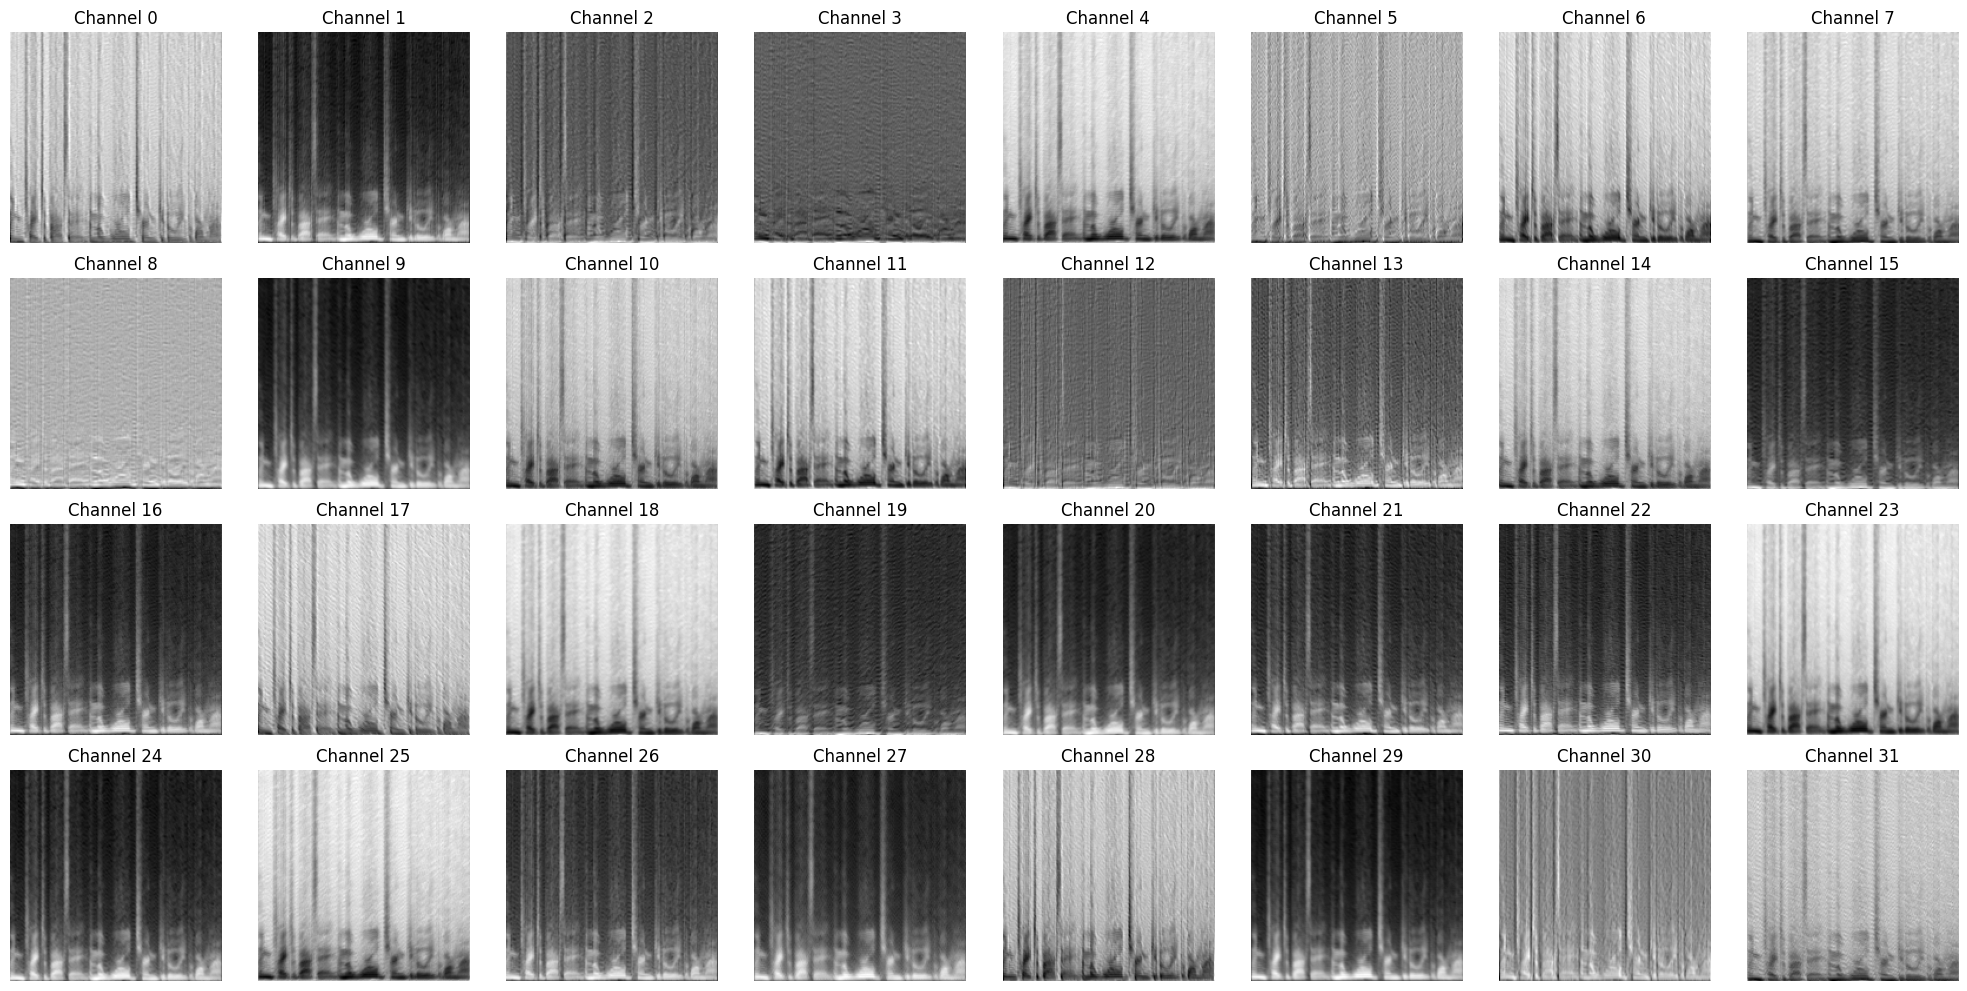

conv2 shape ([C, H, W]): [64, 90, 90]


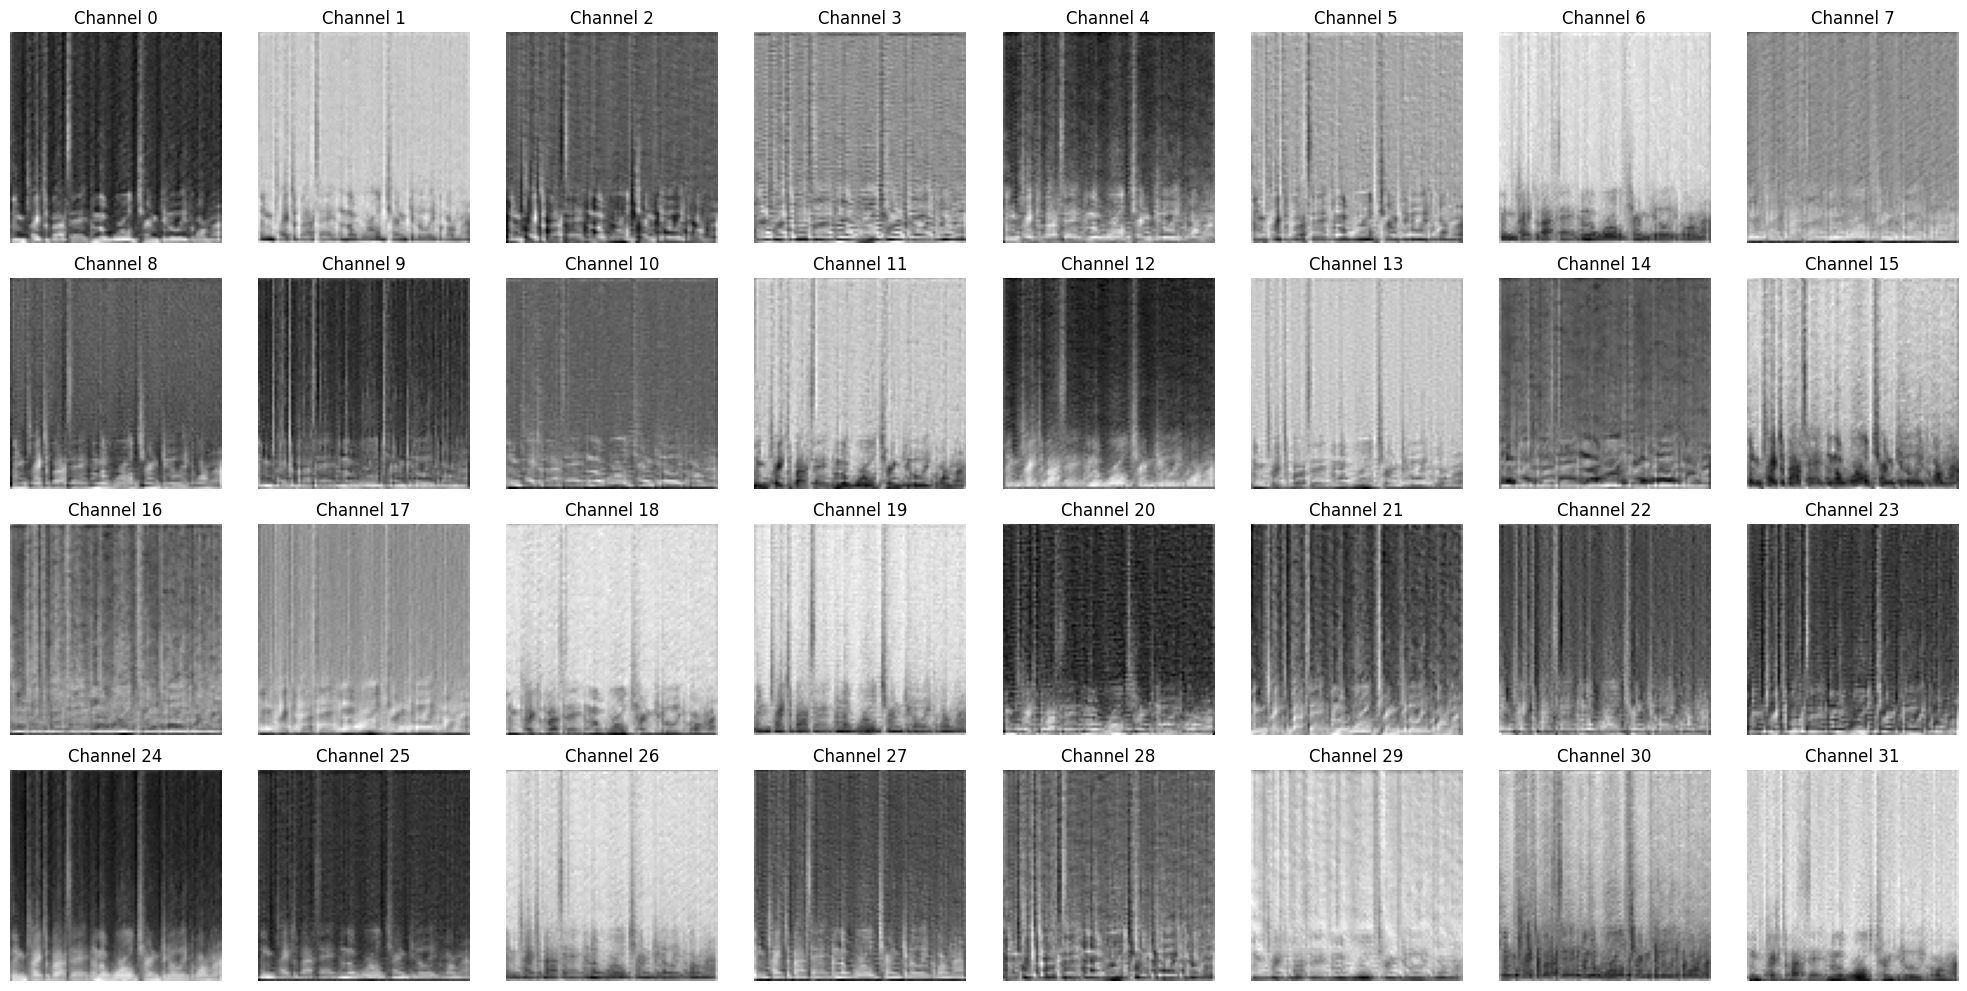

conv3 shape ([C, H, W]): [128, 45, 45]


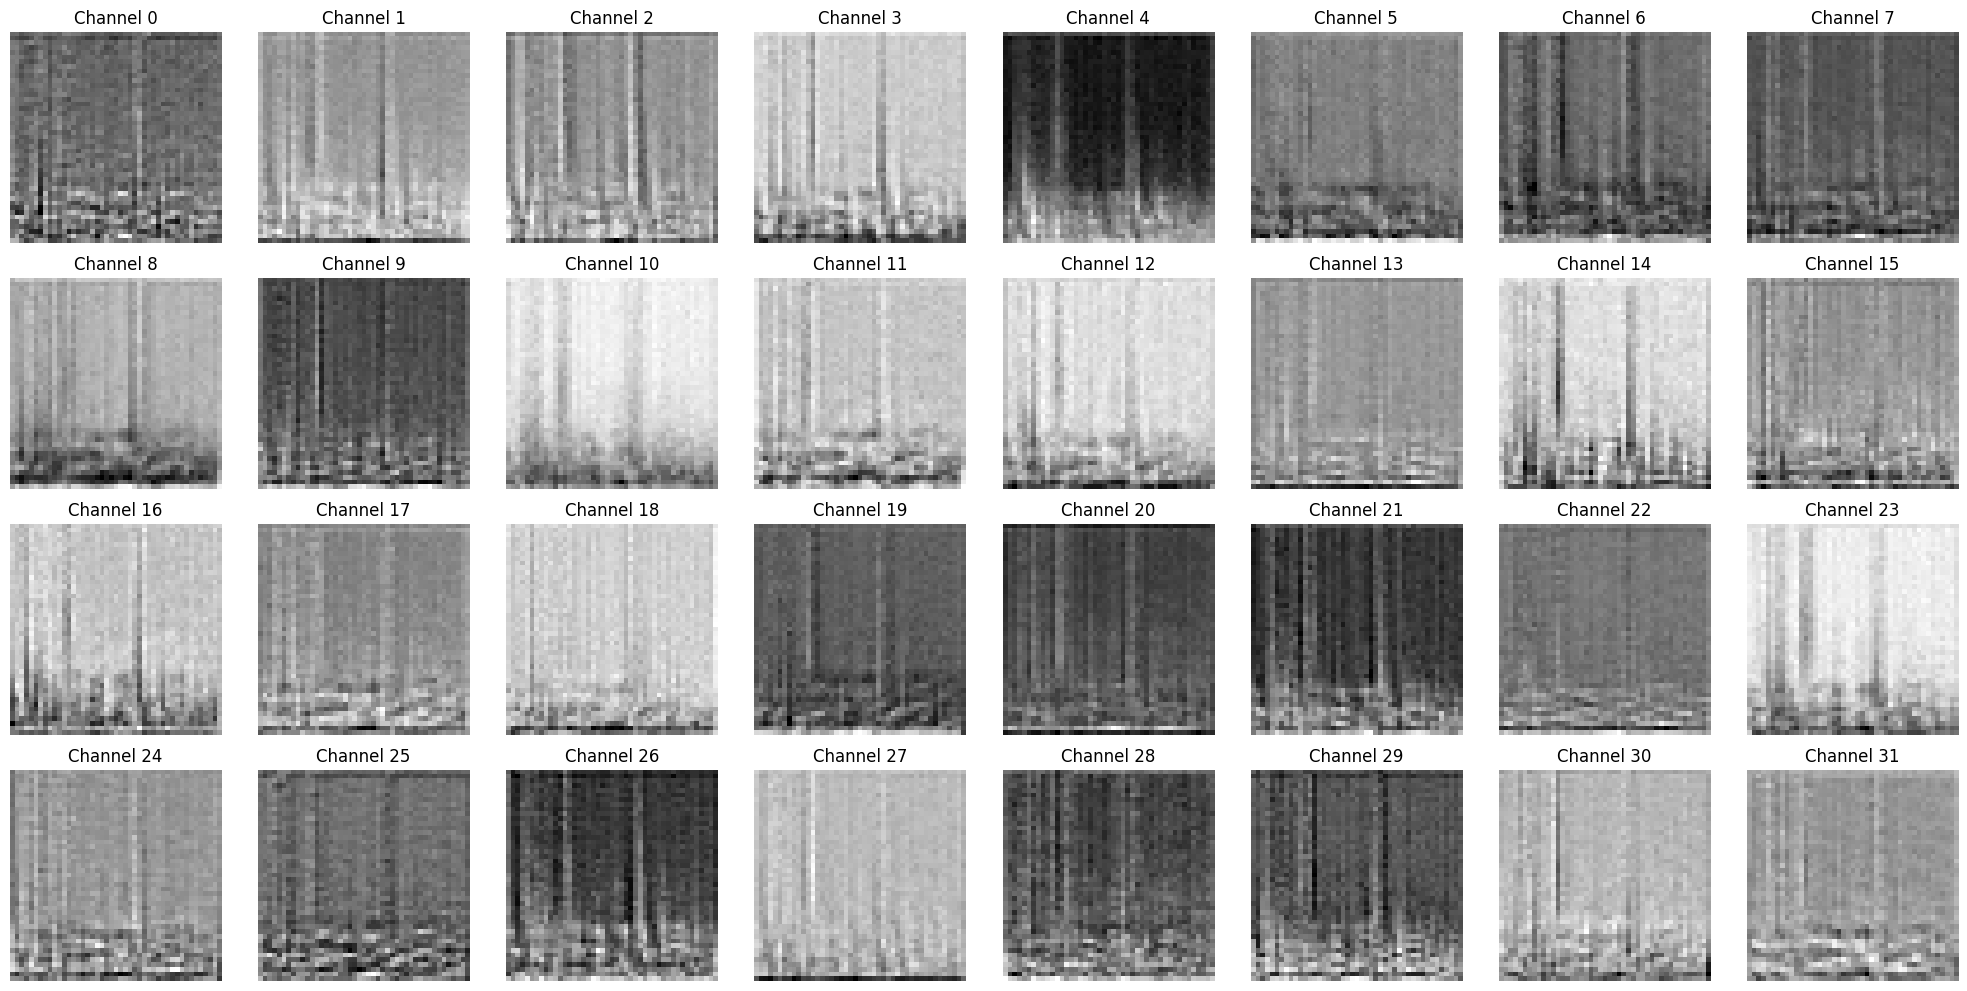

conv4 shape ([C, H, W]): [256, 22, 22]


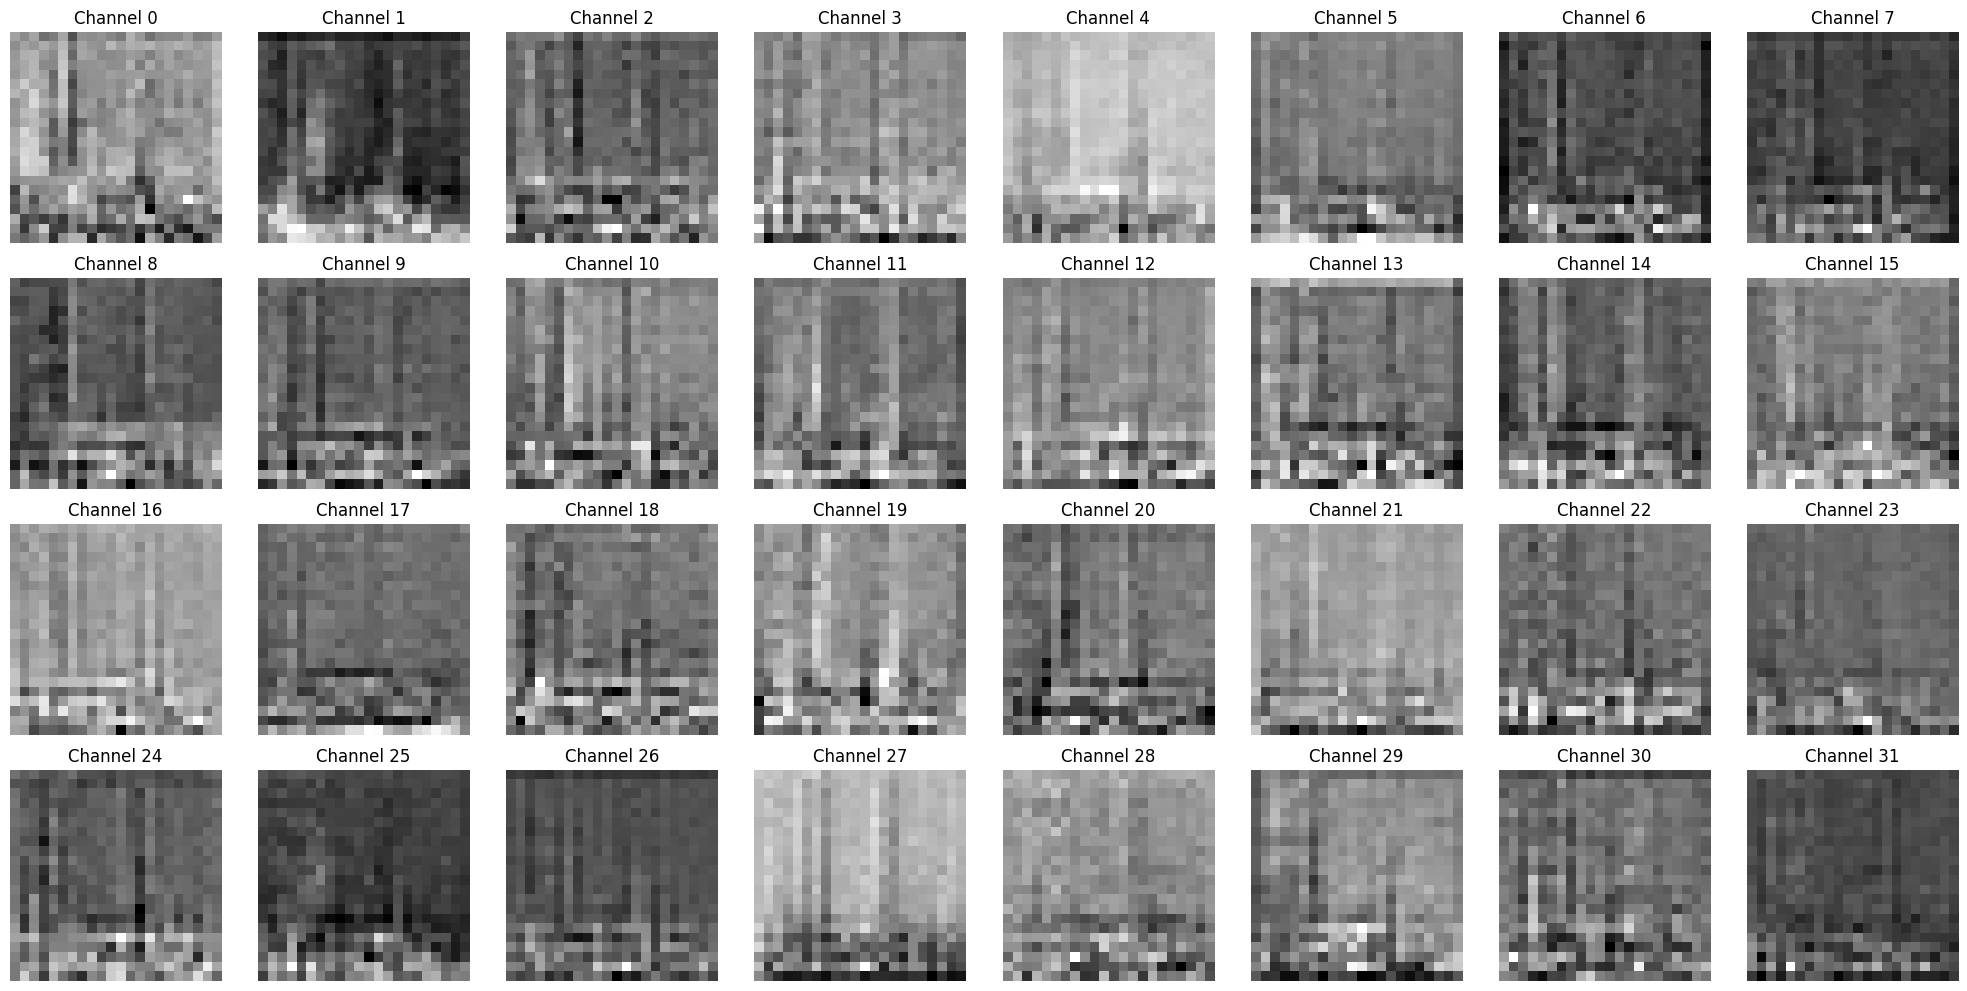

In [39]:
print(f"\n=== Plotting layers for Model 4 ===")
plot_layers(models[3], images) 

### Model testing

In [27]:
for i, model in enumerate(models):
    print(f"\n=== Predictions for Model {i+1} ===")

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted:', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(len(predicted))))


=== Predictions for Model 1 ===


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [28]:

# Modified validation function to compute F1 score
def validation(dataloader, model, loss_fn, t):
    size = len(dataloader.dataset) # total number of images in loader
    num_batches = len(dataloader) # number of batches
    validation_loss, correct = 0, 0
    
    # Store true and predicted labels for F1 score calculation
    all_labels = []
    all_preds = []
    
    model.eval() # Set model to evaluation mode (disables dropout)
    
    with torch.no_grad(): # Disable gradient calculation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) # Make prediction
            validation_loss += loss_fn(pred, y).item()
            
            # Collect predictions and labels for F1
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(pred.argmax(1).cpu().numpy())
            
            # Calculate accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # Loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size
    validation_accuracies.append(accuracy)
    
    # Calculate macro-averaged F1 score
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    # Print validation metrics
    print(f" Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, F1 Score (Macro): {f1_macro:.4f}")


In [29]:
print("Final evaluation on validation set:")
for i, model in enumerate(models):
    print(f"\n=== Final Evaluation for Model {i+1} ===")
    validation(test_set, model, loss_fn, t=epochs)

Final evaluation on validation set:

=== Final Evaluation for Model 1 ===
 Validation Accuracy: 76.72%, Validation Loss: 0.4526, F1 Score (Macro): 0.6582

=== Final Evaluation for Model 2 ===
 Validation Accuracy: 91.70%, Validation Loss: 0.3168, F1 Score (Macro): 0.8997

=== Final Evaluation for Model 3 ===
 Validation Accuracy: 93.12%, Validation Loss: 0.2083, F1 Score (Macro): 0.9170

=== Final Evaluation for Model 4 ===
 Validation Accuracy: 93.72%, Validation Loss: 0.1810, F1 Score (Macro): 0.9212

=== Final Evaluation for Model 5 ===
 Validation Accuracy: 98.79%, Validation Loss: 0.0492, F1 Score (Macro): 0.9855


## Model comparison plots

In [30]:
def validation(dataloader, model, loss_fn, t):
    size = len(dataloader.dataset)  # total number of images in loader
    num_batches = len(dataloader)  # number of batches
    validation_loss, correct = 0, 0

    # Store true and predicted labels for F1 score calculation
    all_labels = []
    all_preds = []

    model.eval()  # Set model to evaluation mode (disables dropout)

    with torch.no_grad():  # Disable gradient calculation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)  # Make prediction
            validation_loss += loss_fn(pred, y).item()

            # Collect predictions and labels for F1
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(pred.argmax(1).cpu().numpy())

            # Calculate accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size
    validation_accuracies.append(accuracy)

    # Calculate macro-averaged F1 score
    f1_macro = f1_score(all_labels, all_preds, average="macro")

    # Print validation metrics
    return f1_macro


=== Final Evaluation for Model 1 ===

=== Final Evaluation for Model 2 ===

=== Final Evaluation for Model 3 ===

=== Final Evaluation for Model 4 ===

=== Final Evaluation for Model 5 ===


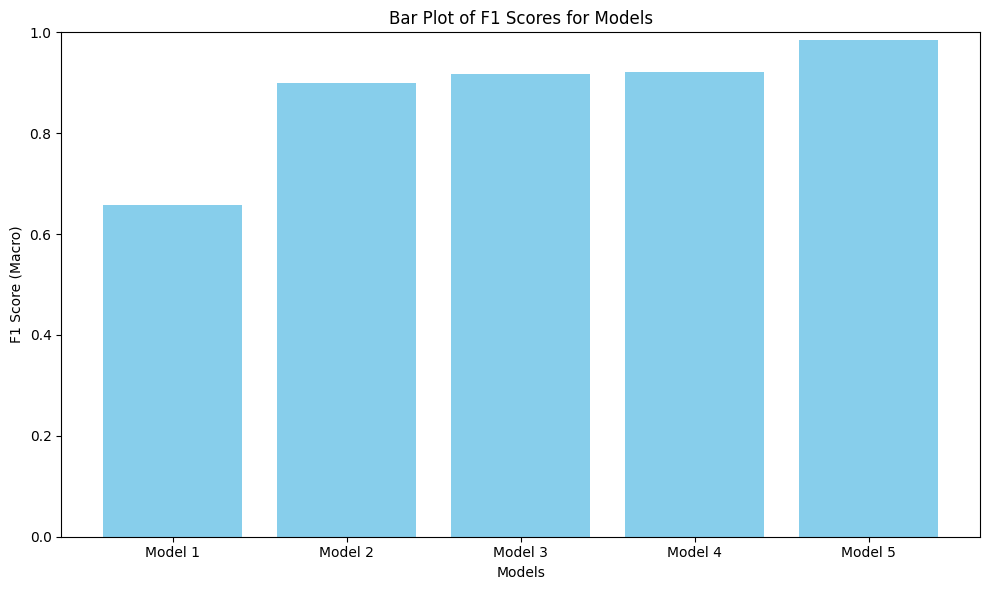

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Store F1 scores for all models
model_f1_scores = []

# Final evaluation on test set with F1 score collection
for i, model in enumerate(models):
    print(f"\n=== Final Evaluation for Model {i+1} ===")
    f1_macro = validation(
        test_set, model, loss_fn, t=epochs
    )  # Assuming validation returns F1 score
    model_f1_scores.append(f1_macro)  # Add F1 score for each model

# Bar plot for F1 Scores
plt.figure(figsize=(10, 6))
plt.bar([f"Model {i+1}" for i in range(len(models))], model_f1_scores, color="skyblue")

# Adding labels and title
plt.title("Bar Plot of F1 Scores for Models")
plt.xlabel("Models")
plt.ylabel("F1 Score (Macro)")
plt.ylim(0, 1)  # F1 score is between 0 and 1, so we set the y-axis limit accordingly

# Display the plot
plt.tight_layout()
plt.show()

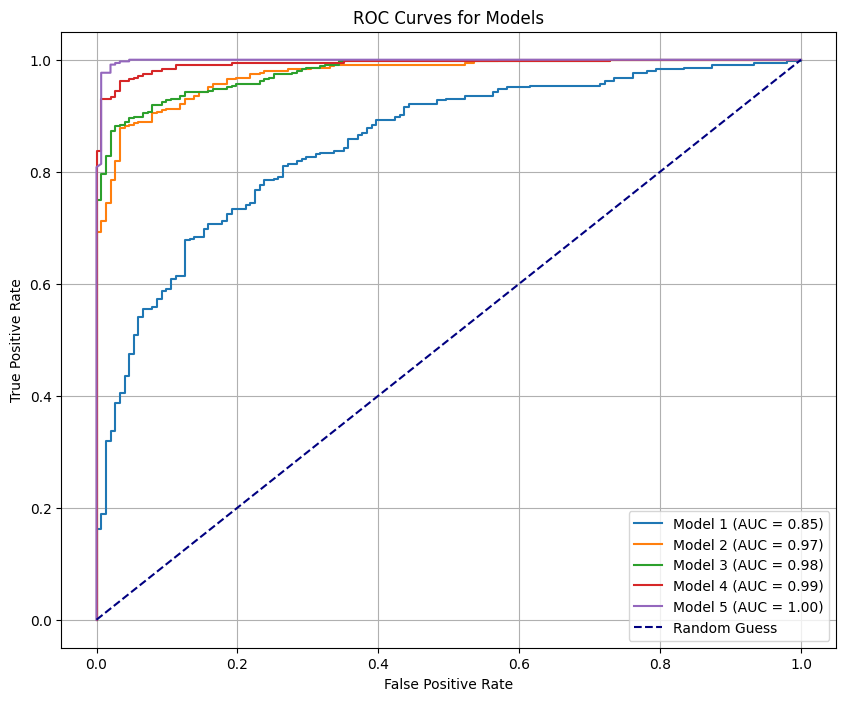

In [32]:
from sklearn.metrics import roc_curve, auc


# Funkcja do obliczenia krzywej ROC dla jednego modelu
def compute_roc(model, dataloader):
    all_labels = []
    all_probs = []

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            probs = torch.softmax(pred, dim=1)

            all_labels.extend(y.cpu().numpy())
            all_probs.extend(
                probs.cpu().numpy()[:, 1]
            )  # Prawdopodobieństwa dla klasy pozytywnej

    fpr, tpr, _ = roc_curve(all_labels, all_probs, pos_label=1)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc


# Generowanie krzywych ROC dla każdego modelu
plt.figure(figsize=(10, 8))
for i, model in enumerate(models):
    fpr, tpr, roc_auc = compute_roc(model, validation_set)
    plt.plot(fpr, tpr, label=f"Model {i+1} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Random Guess")
plt.title("ROC Curves for Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()